In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle, os, subprocess
from itertools import combinations
import scipy
from sklearn.metrics import mean_squared_error

2023-11-09 13:05:39.502292: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
sequences = pd.read_csv('../data/enformer_sequences.bed', header=None, sep='\t')

model_name = 'enformer'
seq_length = 196608
outdir = utils.make_dir('../results/train_test_valid/')

In [3]:
# Trivial but horrible
for fold in sequences[3].unique():

    cmd = f'less ../data/enformer_sequences.bed | grep {fold}  > tmp.bed;'
    cmd += f'bedtools sort -i tmp.bed > tmp_s.bed;'
    cmd += f'bedtools merge -i tmp_s.bed > {outdir}/enformer_{fold}_sequences_merged.bed; rm tmp.bed tmp_s.bed'
    
    results = subprocess.run(
        cmd, shell=True)


In [4]:
context_test_results = pd.read_csv('../results/context_dependence_test/enformer_result_summary.csv')

In [5]:
classified_seq_cell = {}
for cell, cell_context_test_results in context_test_results.groupby('cell line'):
    print(cell)
    ### expand selected TSS sequences to enformer sequence length and save into => ../results/{cell}_tss_selected.bed
    sequences_with_tss = []
    for file_prefix in tqdm([p.split('/')[-1].split('.')[0] for p in cell_context_test_results['path']]):
        chrom_i, tss_i = file_prefix.split('_')[1:3]
        start_i, end_i = int(tss_i) - seq_length//2, int(tss_i) + seq_length//2
        if start_i >= 0:
            sequences_with_tss.append([chrom_i, start_i, end_i])
    print(len(sequences_with_tss))
    pd.DataFrame(sequences_with_tss).to_csv('tmp.bed', sep='\t', header=None, index=None)
    
    cmd = f'bedtools sort -i tmp.bed > {outdir}/{cell}_tss_selected.bed; rm tmp.bed'
    r = subprocess.run(cmd, shell=True)
    print(r)
    fold_seq_dfs = []
    for fold in sequences[3].unique():
        fold_seqs = []
        cell_fold_bed = f'../results/{cell}_{fold}.bed'
        cmd = f'bedtools intersect -a {outdir}/{cell}_tss_selected.bed -b {outdir}/enformer_{fold}_sequences_merged.bed  -wa -f 1.0 > {cell_fold_bed}'
    
        subprocess.run(
            cmd, shell=True)
        df = pd.read_csv(cell_fold_bed, header=None, sep='\t')
        for i, row in df.iterrows():
            paths = glob.glob(f'../results/context_dependence_test/{model_name}/*{row[0]}_{row[1]+seq_length//2}*')
            assert len(paths) == 1, 'too many files found'
            fold_seqs.append(paths[0])
        fold_seqs = pd.DataFrame(fold_seqs)
        fold_seqs.columns=['path']
        fold_seqs['fold'] = fold
        fold_seq_dfs.append(fold_seqs)
    fold_seq_dfs = pd.concat(fold_seq_dfs)
    classified_seqs = cell_context_test_results.merge(fold_seq_dfs, on='path')

    classified_seq_cell[cell] = classified_seqs

GM12878


100%|██████████████████████████████████████████████████████████████████████████████████████| 4950/4950 [00:00<00:00, 999797.98it/s]

4948
CompletedProcess(args='bedtools sort -i tmp.bed > ../results/tran_test_valid//GM12878_tss_selected.bed; rm tmp.bed', returncode=0)


K562


100%|█████████████████████████████████████████████████████████████████████████████████████| 4950/4950 [00:00<00:00, 1031488.71it/s]

4948
CompletedProcess(args='bedtools sort -i tmp.bed > ../results/tran_test_valid//K562_tss_selected.bed; rm tmp.bed', returncode=0)


PC-3


100%|███████████████████████████████████████████████████████████████████████████████████████| 4950/4950 [00:00<00:00, 37076.90it/s]

4948
CompletedProcess(args='bedtools sort -i tmp.bed > ../results/tran_test_valid//PC-3_tss_selected.bed; rm tmp.bed', returncode=0)


In [7]:
folds = sequences[3].unique()
pairs = list(combinations(folds, r=2))
x = 'fold'
y ='delta mean'

train valid 0.057306643662522985
train test 0.05494182989895848
valid test 0.8978159910650102


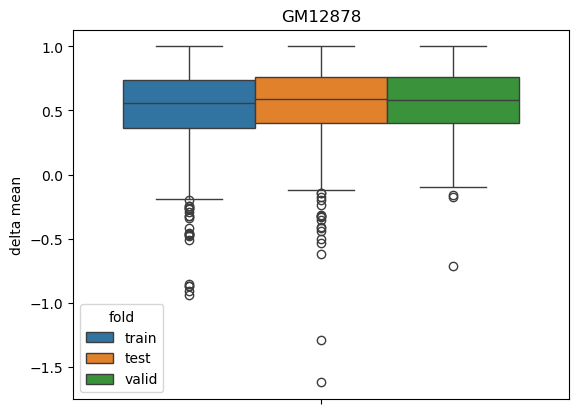

train valid 0.8415811866317484
train test 0.29422520957223286
valid test 0.5965391767888675


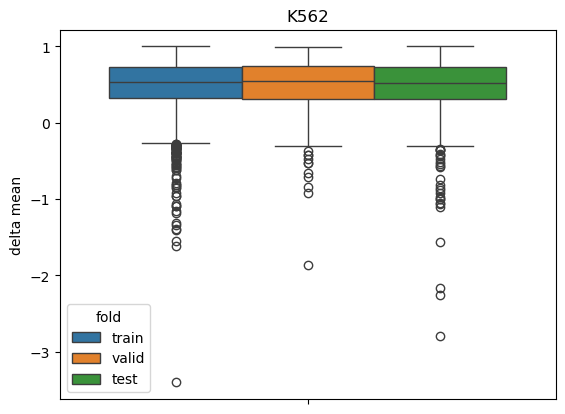

train valid 0.05362742531803131
train test 0.07262559885355338
valid test 0.8443370613276392


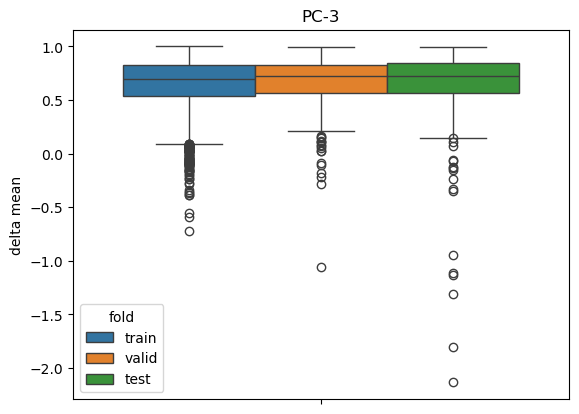

In [48]:
for cell, classified_seqs in classified_seq_cell.items():
    for pair in pairs:
        f1, f2 = pair
        a = classified_seqs[classified_seqs[x]==f1][y]
        b = classified_seqs[classified_seqs[x]==f2][y]
        stat, pvalue = scipy.stats.mannwhitneyu(a, b)
        print(f'{f1} {f2} {pvalue}')

    ax=sns.boxplot(data=classified_seqs, hue=x, y=y)
    plt.title(cell)
    plt.show()